In [2]:
# import libraries 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import skfuzzy as fuzz
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

my_colors_2 = ['#88292F', '#697268', '#12355B', '#D7816A', '#c91e29', '#c33b43', 
               '#9DBF9E', '#cd5a61', '#343934', '#e8da6f','#64a0e0', '#913d27', 
               '#F46036', '#5386E4',  '#bea602', '#0a6682', '#215463']
custom_cmap_2 = LinearSegmentedColormap.from_list('custom_cmap_2', my_colors_2)

In [4]:
# import clean data set

# df_wind = pd.read_csv('../../../../data_analysis_and_preproc/intermediate/wind/df_wind.csv')

In [5]:
# df_wind = df_wind.iloc[:,1:]
# df_wind.head()

In [6]:
# df_wind["read_at"] = pd.to_datetime(df_wind["read_at"]).map(pd.Timestamp.timestamp)

In [7]:
# df_wind["read_at"] = df_wind["read_at"].astype("uint32")
# df_wind["read_at"]

In [8]:
# np.random.seed(1)

# asset = df_wind['asset_id'].unique()[0]

# length = len(df_wind[df_wind['asset_id'] == asset])

# subset_size = int(0.01*length)  # Adjust the percentage as needed

# # Group the DataFrame by the asset identifier column(s)
# grouped = df_wind.groupby('asset_id')

# # Initialize an empty list to store the sampled data
# subset_data = []

# # Iterate over each group, sample subset_size rows from each group, and append to subset_data
# for _, group_df in grouped:
#     sampled_group = group_df.sample(n=subset_size, replace=False)
#     subset_data.append(sampled_group)

# # Concatenate the sampled data from all groups into a single DataFrame
# df_subset = pd.concat(subset_data)

In [9]:
# df_subset.to_csv('df_subset.csv', index = False)

In [10]:
df_subset = pd.read_csv('df_subset.csv')

# Partition Clustering

## K-Means

In [11]:
X = df_subset.loc[:, 'wind_speed':'nacelle_temperature']
X = X.reset_index(drop=True)
X.head()

,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature
0,3.8,227.0,80.0,8.41,12.0,21.0
1,5.2,231.0,165.0,9.93,5.0,20.0
2,8.6,61.0,1013.0,16.26,7.0,12.0
3,3.4,245.0,45.0,7.44,7.0,21.0
4,7.0,271.0,571.0,14.35,0.0,12.0


since this methods are distance based, we should normalize the values

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_scaled.columns= X_scaled.columns.astype(str)

In [22]:
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

pca_df = pd.read_csv('pca_df.csv')

,PC1,PC2
0,-1.253143,-0.763049
1,-0.374977,-1.197599
2,1.976068,-0.386187
3,-1.228114,-1.370854
4,1.454437,-1.465956


In [15]:
# Print explained variance ratio
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Print PCA components (loadings)
print("PCA Components (Loadings):")
print(pd.DataFrame(pca.components_))

Explained Variance Ratio:
[0.57643    0.20976798]
PCA Components (Loadings):
          0         1         2         3         4         5
0  0.493100 -0.026749  0.488803  0.477489 -0.335465 -0.420329
1  0.317188  0.111847  0.296439  0.296952  0.668948  0.513161


[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [08:44<00:00, 22.82s/it]
[clusteval] >INFO> Optimal number clusters detected: [2].
[clusteval] >INFO> Fin.


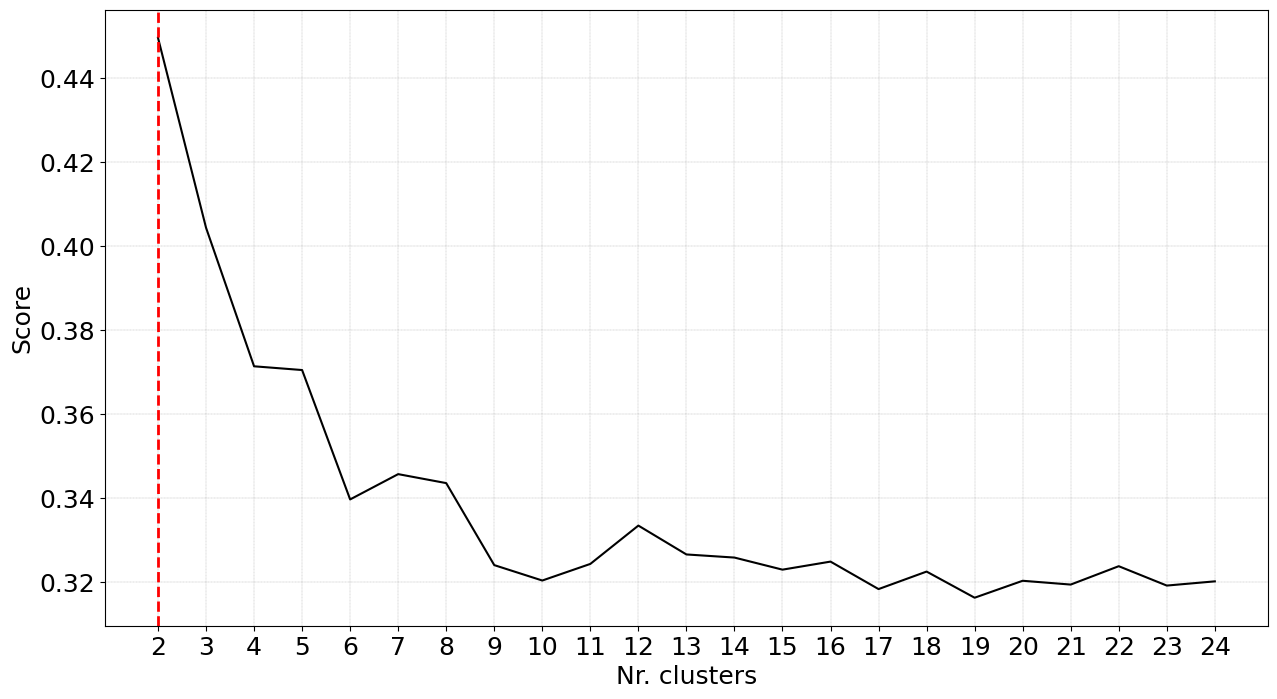

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [16]:
from clusteval import clusteval
# Initialize
ce = clusteval(cluster='kmeans', evaluate='silhouette')

# Fit
ce.fit(pca_df)

# Plot
ce.plot()

### Find the optimal k number by the elbow method

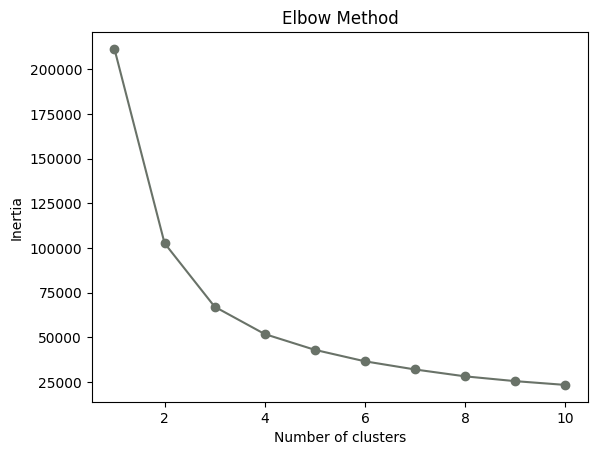

In [160]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,11), inertia, marker = 'o', c = '#697268')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

k = 4, because is where inertia starts decreasing in an almost linear rate

In [1]:
import clustersupport as cs

### Clusters

In [23]:
kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(pca_df)

# Get cluster labels
cluster_labels = kmeans.labels_

In [181]:
with open('results_pca/kmeans_model.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [24]:
df_subset['cluster'] = cluster_labels

In [25]:
df_subset['cluster'].nunique()

2

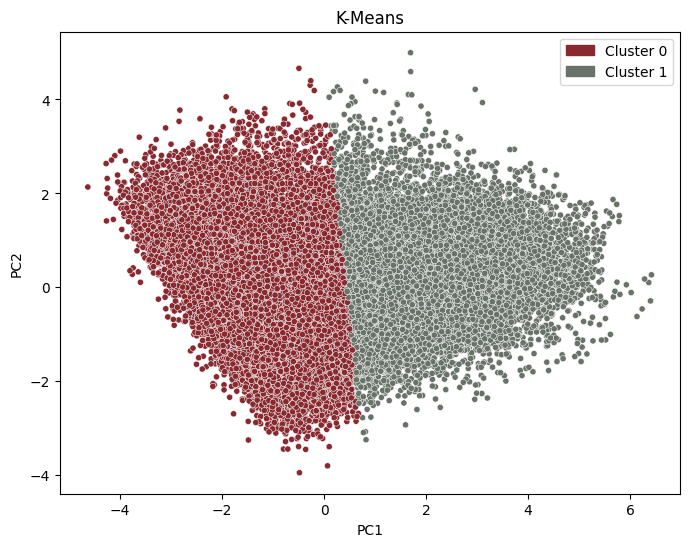

In [26]:
pca_df['cluster'] = df_subset['cluster']

n_clusters = len(pca_df['cluster'].unique())
pallete = sns.color_palette(my_colors_2, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=pallete, s=20)
plt.title('K-Means')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(cluster_labels)])
plt.show()

In [27]:
most_frequent_clusters = df_subset.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_subset = df_subset.drop(columns='cluster')

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,0
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,0
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,0
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,0
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,0


In [179]:
df_subset.to_csv('results_pca/k_means_pca.csv')

In [28]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = df_subset.groupby(['asset_id']).first().reset_index()
representative_points.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,0
1,12,1663674600,2.8,65.0,15.0,6.38,23.0,36.0,1,0
2,13,1623918000,2.4,-95.0,8.0,5.89,13.0,29.0,1,0
3,14,1674150600,16.5,-65.0,2056.0,18.00,5.0,13.0,1,0
4,15,1663676400,3.1,76.0,29.0,7.02,25.0,40.0,1,0


In [29]:
assets_clusters = representative_points.groupby('cluster')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
Cluster 1: [6]


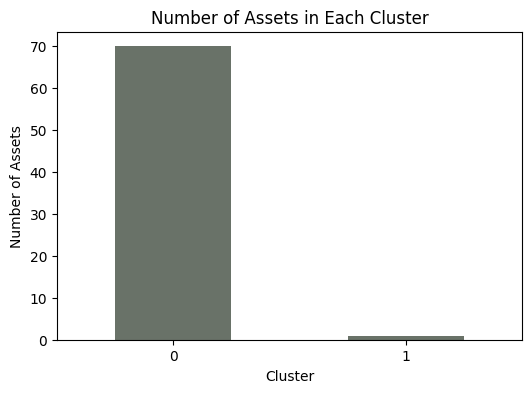

In [30]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [31]:
df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,0
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,0
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,0
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,0
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,0


In [32]:
df_subset = df_subset.iloc[:,:-1]

In [33]:
pca_df = pca_df.iloc[:,:-1]
pca_df.head()

,PC1,PC2
0,-1.253143,-0.763049
1,-0.374977,-1.197599
2,1.976068,-0.386187
3,-1.228114,-1.370854
4,1.454437,-1.465956
